In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
pip install -U scikit-learn

In [ ]:
# Load the dataset
file_path = "/content/time series data.zip"
df = pd.read_csv(file_path)
print(df)

           Date        Asset   Price
0    2023-07-10       Bond B  385.64
1    2023-03-03      Stock B  297.20
2    2023-09-13       Bond B   75.98
3    2023-01-07       Bond B  356.34
4    2023-06-04      Stock A  260.05
..          ...          ...     ...
495  2023-03-30      Stock B  278.00
496  2023-06-27       Bond A  224.26
497  2023-07-16  Commodity A  457.96
498  2023-11-03       Bond B   57.23
499  2023-09-24  Commodity A  401.98

[500 rows x 3 columns]


In [ ]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Select a single asset for ARIMA (choosing the most frequent one)
most_common_asset = df['Asset'].value_counts().idxmax()
df_asset = df[df['Asset'] == most_common_asset]

In [ ]:
# Sort by date
df_asset = df_asset.sort_values(by='Date')

# Set 'Date' as the index for time series analysis
df_asset.set_index('Date', inplace=True)

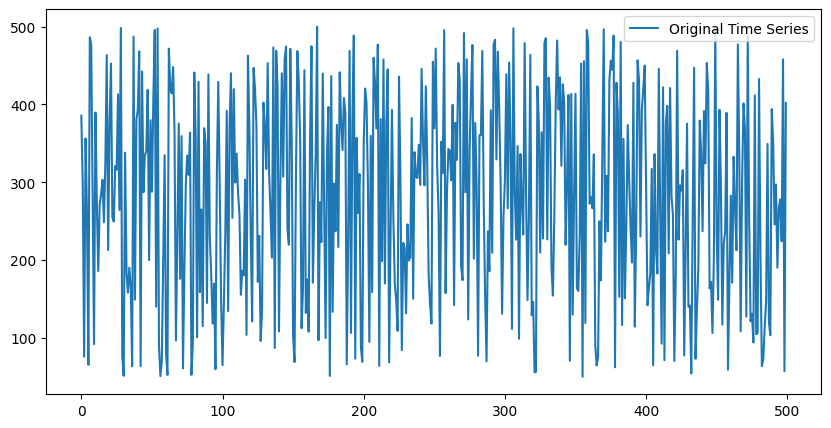

ADF Statistic: -23.03778553104883
p-value: 0.0
The series is stationary (Reject H0)


In [ ]:
# Plot the time series
plt.figure(figsize=(10,5))
plt.plot(df["Price"], label="Original Time Series")
plt.legend()
plt.show()

# Perform ADF Test
adf_test = adfuller(df["Price"])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Interpret results
if adf_test[1] < 0.05:
    print("The series is stationary (Reject H0)")
else:
    print("The series is non-stationary (Fail to reject H0)")

adf statistic is used to find p-values
if p-value < 0.05, the data is stationary

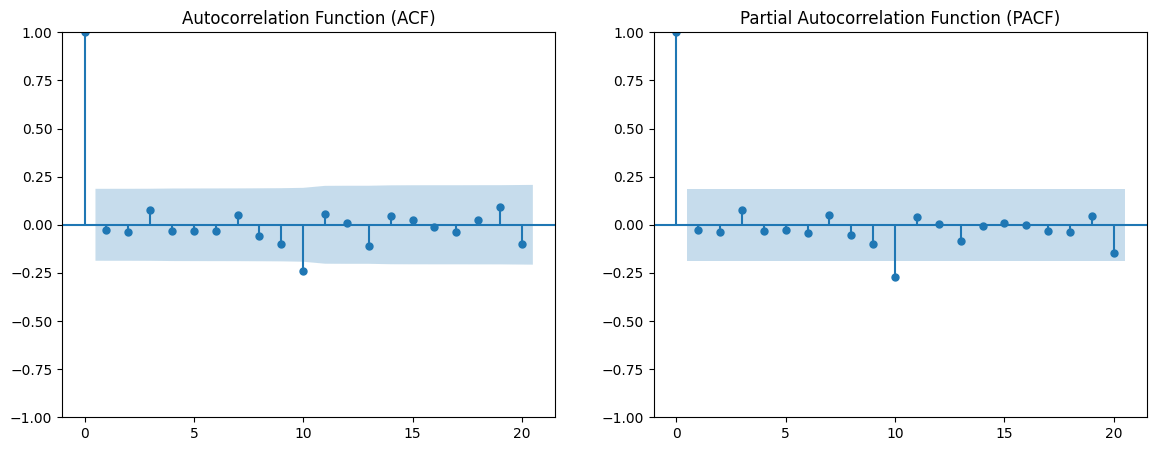

In [ ]:
# Plot ACF and PACF to determine AR (p) and MA (q)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot (identifies q)
plot_acf(df_asset['Price'], lags=20, ax=axes[0])  # Adjust lags if needed
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF Plot (identifies p)
plot_pacf(df_asset['Price'], lags=20, ax=axes[1])  # Adjust lags if needed
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

(MA) component (q) is likely 1 because ACF helps determine q.(AR) component (p) is likely 1 because PACF helps determine p. Data is stationary, no differencing is required (d=0)

In [ ]:
# Train ARIMA(1,0,1) Model
model = ARIMA(df_asset['Price'], order=(1, 0, 1))  # AR(1), no differencing (0), MA(1)
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

AR(1): Uses the previous value to predict the next.
I(0): No differencing needed as the data is stationary.
MA(1): Uses past forecast errors for prediction.

In [ ]:
# Forecast next 10 time steps
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Get actual values for comparison (last 10 known prices)
actual_values = df_asset['Price'].iloc[-forecast_steps:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Split the data into train and test sets
train_size = int(len(df_asset) * 0.8)  # Use 80% for training
train, test = df_asset[:train_size], df_asset[train_size:]


In [ ]:
min_len = min(len(test['Price']), len(forecast))
actual_values = test['Price'].iloc[:min_len]  # Trim test values to match forecast length
predicted_values = forecast[:min_len]  # Trim forecast if necessary


In [ ]:
print(f"Length of actual_values: {len(actual_values)}")
print(f"Length of predicted_values: {len(predicted_values)}")

Length of actual_values: 10
Length of predicted_values: 10


In [ ]:
# Select the last 10 actual prices for comparison
actual_values = test['Price'].iloc[:forecast_steps].reset_index(drop=True).values
predicted_values = forecast.iloc[:forecast_steps].reset_index(drop=True).values

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, forecast)
rmse = np.sqrt(mean_squared_error(actual_values, forecast))
mape = (abs(actual_values - forecast) / actual_values).mean() * 100

In [ ]:
# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 105.6858
Root Mean Squared Error (RMSE): 127.8192
Mean Absolute Percentage Error (MAPE): 62.72%


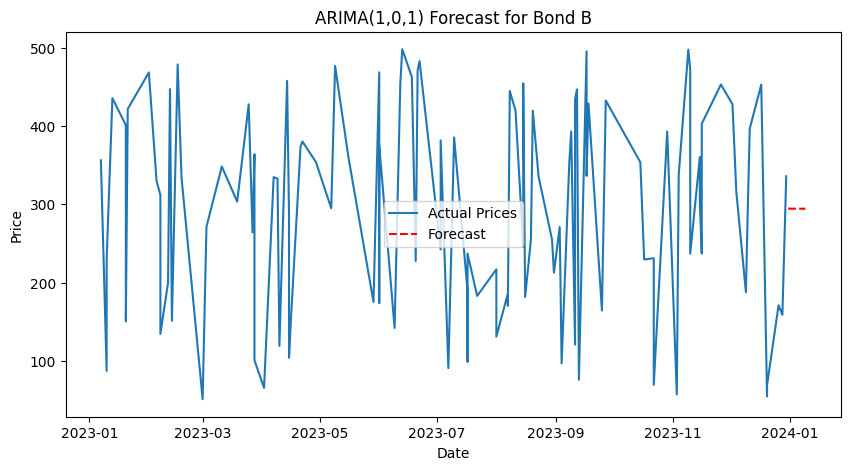

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(df_asset.index, df_asset['Price'], label="Actual Prices")
plt.plot(pd.date_range(df_asset.index[-1], periods=forecast_steps+1, freq='D')[1:],
         forecast, linestyle="dashed", color='red', label="Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"ARIMA(1,0,1) Forecast for {most_common_asset}")
plt.legend()
plt.show()

In [ ]:
# Display the forecasted values
print("Forecasted Prices:")
print(forecast)

Forecasted Prices:
110    294.690836
111    294.519739
112    294.480706
113    294.471801
114    294.469770
115    294.469307
116    294.469201
117    294.469177
118    294.469171
119    294.469170
Name: predicted_mean, dtype: float64


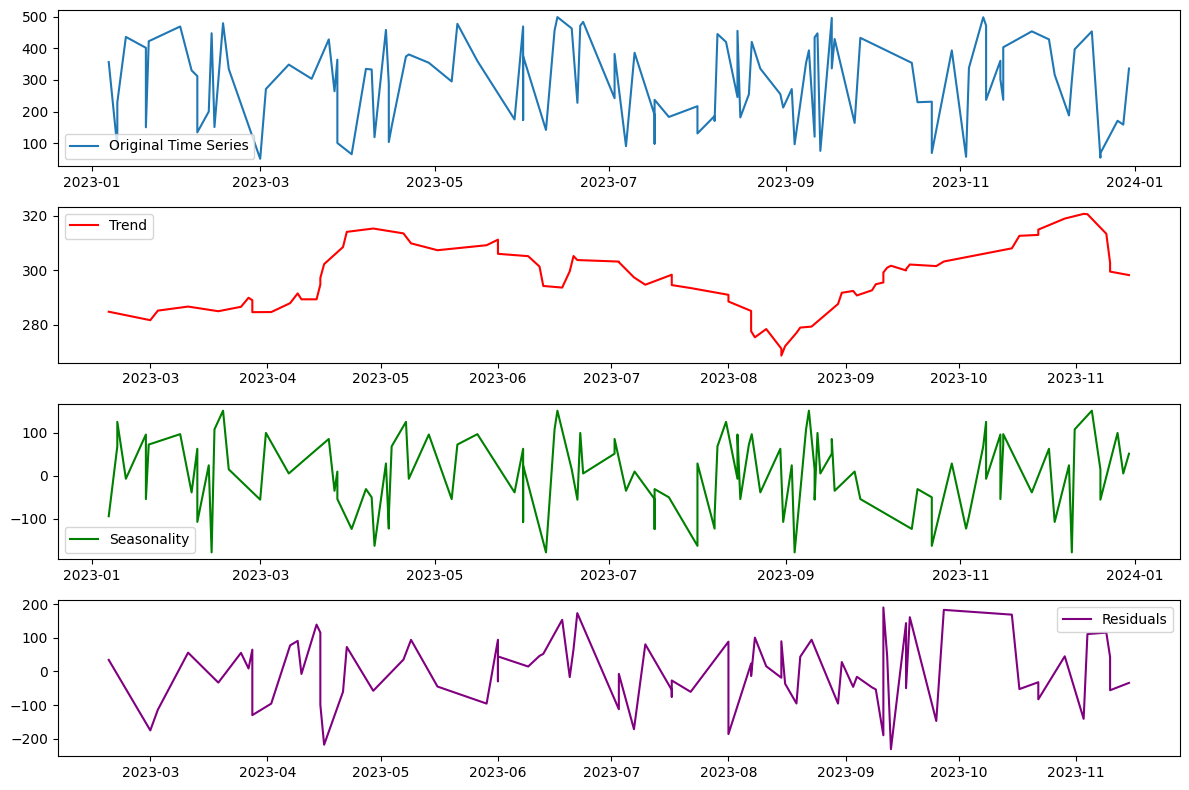

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(df_asset['Price'], model='additive', period=30)  # Assuming monthly seasonality

# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_asset['Price'], label='Original Time Series')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='purple')
plt.legend()

plt.tight_layout()
plt.show()


The trend shows long-term upward and downward movements.
There are periods of increase (e.g., mid-2023) and decrease (e.g., mid-2023 to August).
This suggests that there are underlying forces driving the overall price changes over time.

Seasonality Component
The seasonal component fluctuates regularly, but the pattern is not perfectly smooth.
This suggests that there might be some seasonal effects, but they are weak and irregular.
It does not exhibit a clear, repeating cycle over a fixed period, meaning strong seasonality is not present.

Residuals
The residuals appear random but still exhibit some noticeable spikes and fluctuations.
If ARIMA had fully captured all trends and seasonality, the residuals should have been purely white noise.
Since there are still visible patterns, the ARIMA model may not have fully captured all patterns in the data.
